Paper: https://www.andrew.cmu.edu/user/lakoglu/pubs/StackOverflow-churn.pdf

Description of datasets: https://ia800107.us.archive.org/27/items/stackexchange/readme.txt

Site for download of datasets: https://archive.org/details/stackexchange

This code has 6 steps

1. Load StackOverflow datasets as dataframe
2. Extract and label the datasets for each task
3. Extract features for each task
4. Analyze features
5. Train models for each task with the features
6. Quantify the importance of each feature category

In [1]:
import sys
!{sys.executable} -m pip install xmltodict

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

In [0]:
def store_df_at_google_drive(fname, df):
    s = io.StringIO()
    df.to_csv(s)
    uploaded = gdrive.CreateFile({'title': fname, 'parents':[{'id': 'root'}]})
    uploaded.SetContentString(s.getvalue())
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

def load_df_at_google_drive(fname):
    file_list = gdrive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for file1 in file_list:
        if (file1['title'] == fname):
            downloaded = gdrive.CreateFile({'id': file1['id']})
            s = io.StringIO(downloaded.GetContentString())
            return pd.read_csv(s)
    
def load_dataset_from_google_drive(dir_id):
    files = []
    file_list = gdrive.ListFile({'q': "'{}' in parents".format(dir_id)}).GetList()
    for f in file_list:
      if f['title'] in ['Users.xml', 'Posts.xml','users_reduce.pkl', 'posts_reduce.pkl']:
        print('  Load file: {}'.format(f['title']))
        f_ = gdrive.CreateFile({'id': f['id']})
        f_.GetContentFile(f['title'])
        files.append(f['title'])
    return files

In [5]:
#load_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu')  ### Full dataset
# load_from_google_drive('1haYAgCV-TqTMYIk8N4eGE9H4hY2np5xr')   ### Small dataset
# load_from_google_drive('1CRE27AaxJuX-9Kxtgk2GnmxQt6ECHeJS')   ### Tiny dataset
files = load_dataset_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu')

  Load file: users_reduce.pkl
  Load file: posts_reduce.pkl


1. Load StackOverflow datasets as dataframe

In [0]:
import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [8]:
users_df = pd.read_pickle("{}.pkl".format('users_reduce'))   # shape: (992,110, 3)
posts_df = pd.read_pickle("{}.pkl".format('posts_reduce'))   # shape: (11,324,326, 10)

users_df.shape, posts_df.shape   # Total dataset

((992110, 3), (11324326, 10))

2. Extract and label the datasets for each tasks

You should extract the dataset for the period of the dataset: July 31, 2008 ~ July 31, 2012

There are 2 tasks:

A. After a user's K-th post, predict how likely it is that the user will churn

B. After the T-th day from the account creation of a user, predict how likely it is that the user will churn

In [9]:
def getIthOfPosts(posts):
    print('getIthOfPosts')
    posts.sort_values(by=['OwnerUserId', 'CreationDate'], inplace=True)
    posts.reset_index(level=0, inplace=True)
    posts['id_owner_time'] = posts.index
    first_posts = posts.groupby('OwnerUserId')['id_owner_time'].min().to_frame()
    tmp = posts.join(first_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    posts['ith'] = tmp['id_owner_timeF'] - tmp['id_owner_timeP'] + 1
    posts = posts.drop(['id_owner_time'], axis=1)
    return posts

# You should extract the dataset for the period of the dataset: July 31, 2008 ~  July 31, 2012
start_time = pd.to_datetime('2008-07-31')
end_time = pd.to_datetime('2012-07-31')
end_time_2 = pd.to_datetime('2012-01-31')

posts_df = posts_df[(posts_df['CreationDate'] >= start_time) & (posts_df['CreationDate'] <= end_time)]
users_df = users_df[(users_df['CreationDate'] >= start_time) & (users_df['CreationDate'] <= end_time_2)]

posts_df = getIthOfPosts(posts_df)

getIthOfPosts


In [10]:
display(users_df.head())
# posts_df.set_index('index', inplace=True)
display(posts_df.head())

,Reputation,CreationDate,LastAccessDate
Id,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910


,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith
0,3609905,3,NaN,2010-07-22 18:39:58.787,0.0,-1,0.0,0.0,NaN,2008-07-31,48.0,1
1,3625049,3,NaN,2010-08-01 09:51:37.270,0.0,-1,0.0,0.0,NaN,2008-07-31,8.0,2
2,3625050,3,NaN,2010-08-01 09:51:37.270,0.0,-1,0.0,0.0,NaN,2008-07-31,7.0,3
3,3621159,3,NaN,2010-08-02 06:04:30.050,0.0,-1,0.0,0.0,NaN,2008-07-31,0.0,4
4,3625171,3,NaN,2010-08-02 18:22:47.767,0.0,-1,0.0,0.0,NaN,2008-07-31,176.0,5


In [0]:
# Dataset in Task 1
#   Posts: Extract K posts of each user
#   Users: Extract users who post at least K
def getTask1Users(users, posts, K):
#     users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= K]
    return users

def getTask1Posts(posts, K):
    tmp = posts[posts['ith'] == K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    tmp = posts[posts['OwnerUserId'].isin(tmp.index)]
    return tmp[tmp['ith'] <= K]


In [0]:
list_of_K = range(1, 21)
users_of_task1, posts_of_task1 = {}, {}

users_df['num_posts'] = posts_df.groupby('OwnerUserId')['OwnerUserId'].count()
for K in list_of_K:
    users_of_task1[K] = getTask1Users(users_df, posts_df, K)
    posts_of_task1[K] = getTask1Posts(posts_df, K)


In [14]:
display('users_of_task1[20]:', users_of_task1[20].head())
display('posts_of_task1[20]:', posts_of_task1[20].head())

'users_of_task1[20]:'

,Reputation,CreationDate,LastAccessDate,num_posts
Id,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,322.0


'posts_of_task1[20]:'

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith
0,3609905,3,NaN,2010-07-22 18:39:58.787,0.0,-1,0.0,0.0,NaN,2008-07-31,48.0,1
1,3625049,3,NaN,2010-08-01 09:51:37.270,0.0,-1,0.0,0.0,NaN,2008-07-31,8.0,2
2,3625050,3,NaN,2010-08-01 09:51:37.270,0.0,-1,0.0,0.0,NaN,2008-07-31,7.0,3
3,3621159,3,NaN,2010-08-02 06:04:30.050,0.0,-1,0.0,0.0,NaN,2008-07-31,0.0,4
4,3625171,3,NaN,2010-08-02 18:22:47.767,0.0,-1,0.0,0.0,NaN,2008-07-31,176.0,5


In [0]:
import warnings
warnings.filterwarnings(action='ignore')

# Churn in Task 1
#   Churners: Users who did not post for at least 6 months from their K-th post 
#   Stayers:  Users who created at least one post within the 6 months from their K-th post
def prepareFeaturesTask1(users, posts, K):
    tmp = posts[posts['ith']==K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    posts = posts[posts['OwnerUserId'].isin(tmp.index)]

    posts_task = posts[posts['OwnerUserId'].isin(users.index)]
    posts_Kth_time = posts_task[posts_task['ith']==K]
    posts_Kth_time = posts_Kth_time.set_index('OwnerUserId')['CreationDate']
    posts_deadline = posts_Kth_time + pd.tseries.offsets.DateOffset(months=6)
    
    posts_stayer = posts_task[posts_task['ith'] > K].groupby('OwnerUserId')['CreationDate'].min().to_frame()
    posts_stayer = posts_stayer.merge(posts_deadline, on='OwnerUserId', how='left', suffixes=('_left', '_right'))
    
    posts_churner1 = posts_stayer[posts_stayer['CreationDate_left'] > posts_stayer['CreationDate_right']]
    posts_churner1['is_churn'] = 1
    posts_churner1 = posts_churner1[['is_churn']]
    posts_stayer = posts_stayer[posts_stayer['CreationDate_left'] <= posts_stayer['CreationDate_right']]
    posts_stayer['is_churn'] = 0    
    posts_stayer = posts_stayer[['is_churn']]
       
    posts_churner2 = posts_task[posts_task['ith'] >= K].groupby('OwnerUserId').count()
    posts_churner2 = posts_churner2[posts_churner2['CreationDate'] == 1][['CreationDate']]
    posts_churner2['is_churn'] = 1
    posts_churner2 = posts_churner2[['is_churn']]
    
    posts = pd.concat([posts_stayer, posts_churner1, posts_churner2])
    posts = posts.rename(columns={'OwnerUserId': 'Id'})
    users['is_churn'] = 0
    users.update(posts)
    return users

features_of_task1 = {}

for K in list_of_K:
    features_of_task1[K] = prepareFeaturesTask1(users_of_task1[K], posts_df, K)
  

In [16]:
display('features_of_task1[20]:', features_of_task1[20].head())

'features_of_task1[20]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn
Id,,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0,0.0
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0,0.0
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0,0.0
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0,0.0
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,322.0,0.0


In [0]:
# Dataset in Task 2
#   Users: Extract users who post at least 1
#   Posts: Extract posts which create before T day from the account creation of the owner
def getTask2Users(users, posts):
#     users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= 1]
    return users
  
def getTask2Posts(users, posts, T):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    observation_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    posts = posts[posts['CreationDate'] <= observation_deadline]
    return posts
  
def getCreationDateOfOwner(users, posts):
    posts['DataframeIndex'] = posts.index
    posts['CreationDateOfOwner'] = posts.set_index('OwnerUserId')\
            .join(users, how='inner', rsuffix='OfOwner')\
            .set_index('DataframeIndex')['CreationDateOfOwner']
    posts = posts.drop(['DataframeIndex'], axis=1)
    return posts['CreationDateOfOwner']

list_of_T = [7, 15, 30]
users_of_task2 = {}
posts_of_task2 = {}

users_df['num_posts'] = posts_df.groupby('OwnerUserId')['OwnerUserId'].count()
for T in list_of_T:
    users_of_task2[T] = getTask2Users(users_df, posts_df)
    posts_of_task2[T] = getTask2Posts(users_df, posts_df, T)


In [18]:
display("users_of_task2[30]:", users_of_task2[30].head())
display('posts_of_task2[30]:', posts_of_task2[30].head())

'users_of_task2[30]:'

,Reputation,CreationDate,LastAccessDate,num_posts
Id,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283,11.0
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0


'posts_of_task2[30]:'

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith,DataframeIndex
3126,9,1,1404.0,2008-07-31 23:40:59.743,1742.0,1,63.0,5.0,NaN,2008-07-31 14:22:31.287,16.0,1,3126
3127,11,1,1248.0,2008-07-31 23:55:37.967,1444.0,1,37.0,3.0,NaN,2008-07-31 14:22:31.287,23.0,2,3127
3128,12,2,NaN,2008-07-31 23:56:41.303,327.0,1,0.0,11.0,11.0,2008-07-31 14:22:31.287,194.0,3,3128
3129,986,2,NaN,2008-08-04 02:45:07.717,3.0,1,0.0,0.0,944.0,2008-07-31 14:22:31.287,117.0,4,3129
3130,1016,2,NaN,2008-08-04 04:31:02.557,12.0,1,0.0,0.0,944.0,2008-07-31 14:22:31.287,47.0,5,3130


In [0]:
# Churn in Task2
#   Churners: Users who did not post for at least 6 months from T days after account creation
#   Stayers:  Users who created at least one post within the 6 months from T days after account creation

def prepareFeaturesTask2(users, posts, T=30):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    users = getTask1Users(users, posts, K=1)
    observe_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    churn_deadline = observe_deadline + pd.tseries.offsets.DateOffset(months=6)
    posts_observed = posts[(posts['CreationDate'] <= observe_deadline) & (posts['CreationDate'] >= posts['CreationDateOfOwner'])]
    posts_after_observe = posts[(posts['CreationDate'] <= churn_deadline) & (posts['CreationDate'] > observe_deadline)]
    label_df = users.reindex((posts_observed.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index)
    stayers = (posts_after_observe.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index
    churners = list(set(label_df.index) - set(stayers))
    label_df['is_churn'] = 0.
    label_df.loc[churners, 'is_churn'] = 1.
    return label_df

features_of_task2 = {}
for T in list_of_T:
    features_of_task2[T] = prepareFeaturesTask2(users_of_task2[T], posts_df, T)


In [20]:
display('features_of_task2[30]:', features_of_task2[30].head())

'features_of_task2[30]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn
OwnerUserId,,,,,
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0,0.0
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283,11.0,0.0
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0,0.0
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0,0.0
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,322.0,0.0


3. Extract features for each task

3-1. Temporal features

In [0]:
# Temporal features 1: gap1
def getTimeGap1OfUser(users, posts):
    creation_date_user = users['CreationDate']
    creation_date_first_post = posts.groupby('OwnerUserId')['CreationDate'].min()
    return (creation_date_first_post - creation_date_user).dt.total_seconds()

In [0]:
# Temporal features 2: gapK
def getTimeGapkOfPosts(posts, k):
    date_1 = posts[posts['ith'] == (k-1)].sort_values('OwnerUserId')
    date_2 = posts[posts['ith'] == k].sort_values('OwnerUserId')
    date_2 = date_2.set_index('OwnerUserId')
    date_1 = date_1.set_index('OwnerUserId')
    result = (date_2['CreationDate'] - date_1['CreationDate']).dt.total_seconds() / 60  
    return result

In [0]:
# Temporal features 3: last_gap
def getTimeLastGapOfPosts(posts):
    last_posts = posts.groupby('OwnerUserId')['CreationDate'].max().to_frame()
    tmp = posts.join(last_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    tmp = tmp[tmp['CreationDateF'] < tmp['CreationDateP']].groupby('OwnerUserId')['CreationDateF'].max().to_frame()
    return (last_posts['CreationDate'] - tmp['CreationDateF']).dt.total_seconds() / 60

In [0]:
# Temporal features 4: time_since_last_post
def getTimeSinceLastPost(users, posts, T):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    creation_after_T_days_date = users['CreationDate'] + pd.offsets.Day(T)
    return (creation_after_T_days_date - last_post_date).dt.total_seconds() / 60


In [0]:
# Temporal features 5: mean_gap
def getTimeMeanGap(posts):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    first_post_date = posts.groupby('OwnerUserId')['CreationDate'].min()
    num_posts = posts.groupby('OwnerUserId')['CreationDate'].count()
    return (last_post_date - first_post_date).dt.total_seconds() / 60 / num_posts


In [0]:
# Extract temporal features for task1
for K in list_of_K:
    features_of_task1[K]['gap1'] = getTimeGap1OfUser(users_of_task1[K], posts_of_task1[K])
    for k in range(2, K+1):
        features_of_task1[K]['gap{}'.format(k)] = getTimeGapkOfPosts(posts_of_task1[K], k)

In [27]:
display('features_of_task1[20]:', features_of_task1[20].head())

'features_of_task1[20]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,gap2,gap3,gap4,gap5,gap6,gap7,gap8,gap9,gap10,gap11,gap12,gap13,gap14,gap15,gap16,gap17,gap18,gap19,gap20
Id,,,,,,,,,,,,,,,,,,,,,,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0,0.0,6.236160e+07,13871.641383,0.000000,1212.879667,738.295283,0.000000,3821.372833,0.000000,446.409433,0.000000,30909.906500,0.000000,6338.125283,2520.863217,0.249617,0.450050,0.564450,0.104550,0.208233,0.679933
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0,0.0,3.350846e+04,14.637067,1.055600,4488.440233,105.914000,213.653000,8664.172717,2094.917667,306.937167,268.860450,3.240600,1090.866950,14.210383,243.079450,163.205617,348.912383,907.278667,3.568500,3.356383,630.739500
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0,0.0,3.178287e+05,963.251067,18479.137883,14094.074217,2354.710283,887.694667,22378.701500,31136.498217,54922.305567,1466.621767,7.396783,2751.420833,67935.440000,10076.188950,47.300550,2298.722167,45.351833,2069.401117,2602.263883,300.081167
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0,0.0,1.316662e+06,6231.270117,1069.794717,6.940950,262.458550,682.875667,1481.491500,2221.188050,2971.120117,28257.784883,2227.568950,904.651550,70.010450,4454.531500,5747.542333,11599.646050,47197.588500,16359.198733,26448.735667,3808.643217
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,322.0,0.0,1.402711e+05,4299.353500,2448.063883,1243.589000,7.128450,47.845000,114.664383,5.675050,5601.351500,1256.390733,205.077600,49.783333,1678.190117,445.529717,40.191333,15.179400,17.122933,28.284567,867.795000,265.515767


K=1


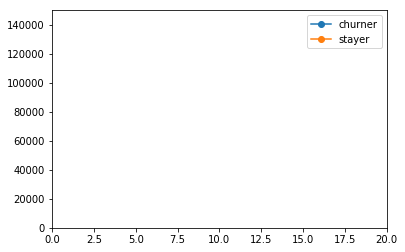

K=2


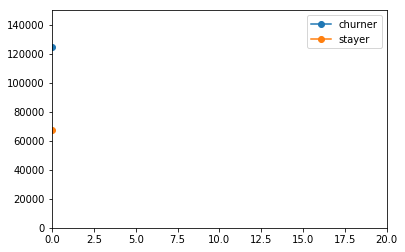

K=3


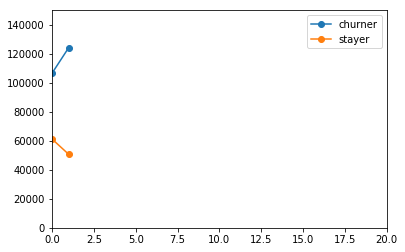

K=4


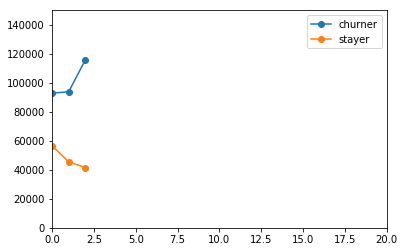

K=5


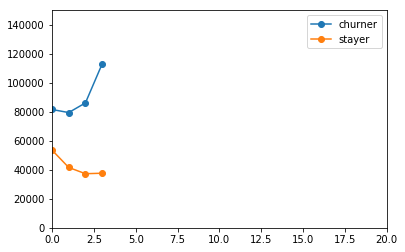

K=6


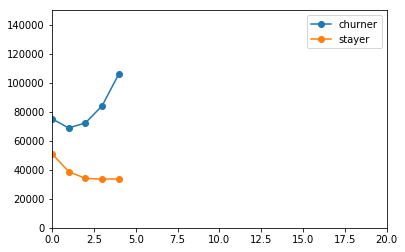

K=7


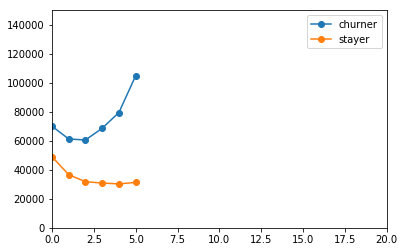

K=8


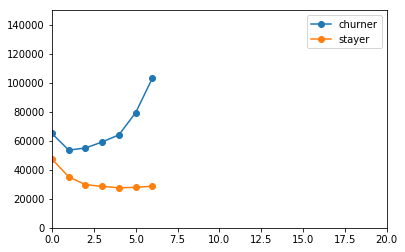

K=9


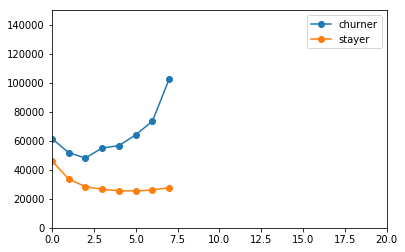

K=10


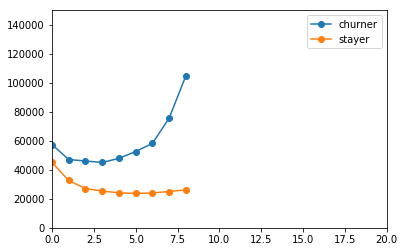

K=11


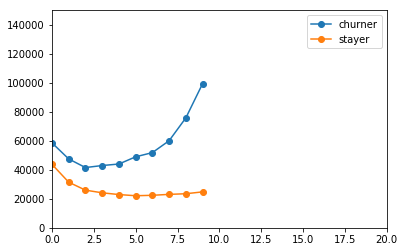

K=12


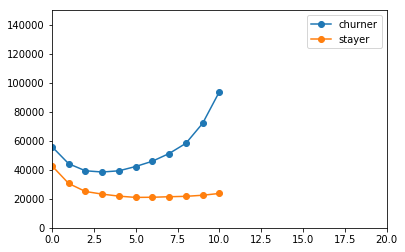

K=13


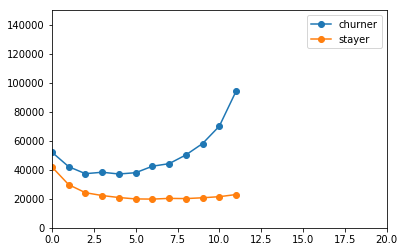

K=14


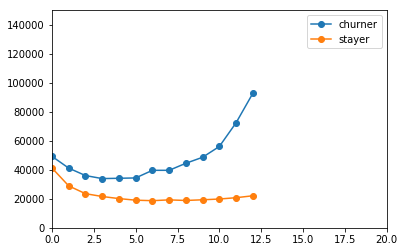

K=15


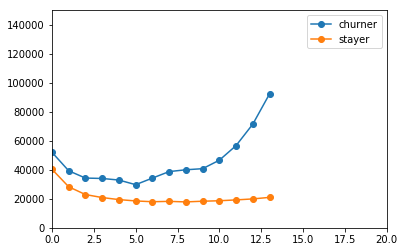

K=16


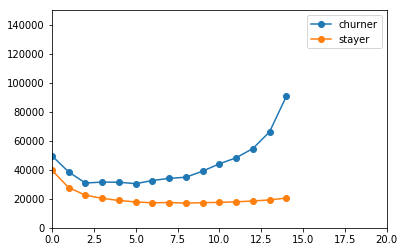

K=17


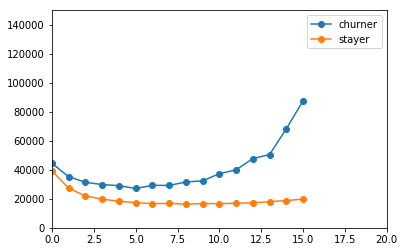

K=18


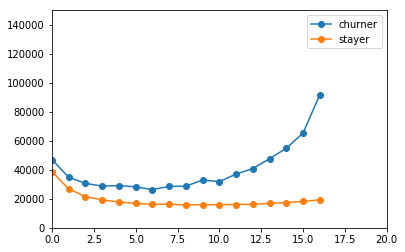

K=19


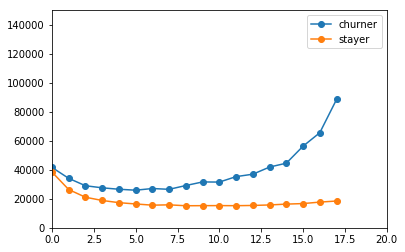

K=20


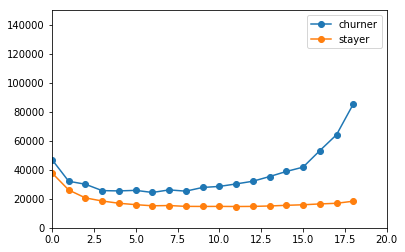

In [28]:
# Figure 2: Gap between posts
#    For a user who churns, gap between consecutive posts keeps increasing. 
#    Gaps for those who stay are much lower, and stabilize around 20,000 minutes,
#    indicating routine posting activity in every ≈2 weeks.
clist = []
slist = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners_gap = []
    stayers_gap = []
    for i in range(2, K+1):
        gapK = 'gap{}'.format(i)
        sum_gapK = list(subgroup.groupby('is_churn')[gapK].sum())
        count_gapK = list(subgroup.groupby('is_churn')[gapK].count())
        if len(sum_gapK) < 2:
            break
        churners_gap.append(sum_gapK[1] / count_gapK[1]) # churner's average gap
        stayers_gap.append(sum_gapK[0] / count_gapK[0]) # stayer's average gap

    clist.append(churners_gap)
    slist.append(stayers_gap)
    
    print("K={}".format(K))
    plt.plot(churners_gap, '-o', label='churner')
    plt.plot(stayers_gap, '-o', label='stayer')
    plt.legend()
    plt.axis((0,20,0,15e4))
    plt.show()

In [29]:
display(list_of_K)
display(len(clist[19]))
len(clist[1:])
len(clist[-4:])

range(1, 21)

19

4

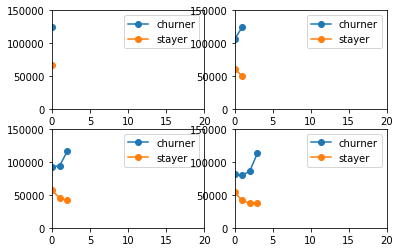

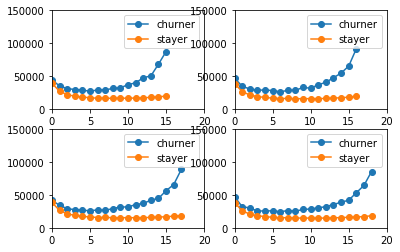

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[1:], slist[1:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[-4:], slist[-4:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

In [0]:
# Extract temporal features for task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['gap1'] = getTimeGap1OfUser(users, posts)
    features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(features_of_task2[T]['gap1'])
    #features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(0)
    features_of_task2[T]['time_since_last_post'] = getTimeSinceLastPost(users, posts, T)
    features_of_task2[T]['mean_gap'] = getTimeMeanGap(posts)


In [32]:
display('features_of_task2[30]:', features_of_task2[30].head())

'features_of_task2[30]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,last_gap,time_since_last_post,mean_gap
OwnerUserId,,,,,,,,,
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0,0.0,33508.456,122.473267,2936.057733,1323.515600
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283,11.0,0.0,52622.356,25381.910000,12568.666733,7438.573500
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0,0.0,317828.716,887.694667,1123.986617,6129.811353
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0,0.0,1316661.823,2971.120117,6328.496617,1658.571074
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,322.0,0.0,140271.080,63.865383,2484.611900,511.700490


3-2. Frequency features

In [0]:
# Frequency features 1: num_answers
# Frequency features 2: num_questions
def getNumAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['OwnerUserId'].count()

def getNumQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['OwnerUserId'].count()


In [0]:
# Frequency features 3: ans_ques_ratio
def getAnsQuesRatio(num_answers, num_questions):
    # Use Laplace Smoothing
    return (num_answers + 1) / (num_questions + 1)


In [0]:
# Frequency features 4: num_posts
def getNumPosts(posts):
    return posts.groupby('OwnerUserId')['OwnerUserId'].count().astype('float')

In [0]:
# Extract frequency features of task1
for K in list_of_K:
    users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['num_answers'] = getNumAnswers(posts)
    features_of_task1[K]['num_questions'] = getNumQuestions(posts)
    features_of_task1[K] = features_of_task1[K].fillna({'num_answers':0, 'num_questions':0})
    features_of_task1[K]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task1[K]['num_answers'], features_of_task1[K]['num_questions'])

In [37]:
display('features_of_task1[20]:', features_of_task1[20].head())

'features_of_task1[20]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,gap2,gap3,gap4,gap5,gap6,gap7,gap8,gap9,gap10,gap11,gap12,gap13,gap14,gap15,gap16,gap17,gap18,gap19,gap20,num_answers,num_questions,ans_que_ratio
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0,0.0,6.236160e+07,13871.641383,0.000000,1212.879667,738.295283,0.000000,3821.372833,0.000000,446.409433,0.000000,30909.906500,0.000000,6338.125283,2520.863217,0.249617,0.450050,0.564450,0.104550,0.208233,0.679933,0.0,0.0,1.000000
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0,0.0,3.350846e+04,14.637067,1.055600,4488.440233,105.914000,213.653000,8664.172717,2094.917667,306.937167,268.860450,3.240600,1090.866950,14.210383,243.079450,163.205617,348.912383,907.278667,3.568500,3.356383,630.739500,17.0,3.0,4.500000
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0,0.0,3.178287e+05,963.251067,18479.137883,14094.074217,2354.710283,887.694667,22378.701500,31136.498217,54922.305567,1466.621767,7.396783,2751.420833,67935.440000,10076.188950,47.300550,2298.722167,45.351833,2069.401117,2602.263883,300.081167,17.0,3.0,4.500000
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0,0.0,1.316662e+06,6231.270117,1069.794717,6.940950,262.458550,682.875667,1481.491500,2221.188050,2971.120117,28257.784883,2227.568950,904.651550,70.010450,4454.531500,5747.542333,11599.646050,47197.588500,16359.198733,26448.735667,3808.643217,18.0,2.0,6.333333
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,322.0,0.0,1.402711e+05,4299.353500,2448.063883,1243.589000,7.128450,47.845000,114.664383,5.675050,5601.351500,1256.390733,205.077600,49.783333,1678.190117,445.529717,40.191333,15.179400,17.122933,28.284567,867.795000,265.515767,19.0,1.0,10.000000


In [0]:
# Extract frequency features of task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['num_answers'] = getNumAnswers(posts)
    features_of_task2[T]['num_questions'] = getNumQuestions(posts)
    features_of_task2[T] = features_of_task2[T].fillna({'num_answers':0,'num_questions':0})
    features_of_task2[T]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task2[T]['num_answers'], features_of_task2[T]['num_questions'])
    features_of_task2[T]['num_posts'] = getNumPosts(posts)

In [39]:
display('features_of_task2[30]:', features_of_task2[30].head())

'features_of_task2[30]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,last_gap,time_since_last_post,mean_gap,num_answers,num_questions,ans_que_ratio
OwnerUserId,,,,,,,,,,,,
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,30.0,0.0,33508.456,122.473267,2936.057733,1323.515600,26.0,4.0,5.400000
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283,4.0,0.0,52622.356,25381.910000,12568.666733,7438.573500,1.0,3.0,0.500000
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,6.0,0.0,317828.716,887.694667,1123.986617,6129.811353,5.0,1.0,3.000000
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,9.0,0.0,1316661.823,2971.120117,6328.496617,1658.571074,9.0,0.0,10.000000
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,75.0,0.0,140271.080,63.865383,2484.611900,511.700490,67.0,8.0,7.555556


# Answers vs Churn probability


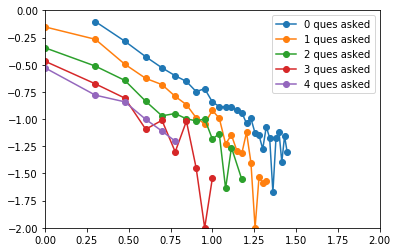

# Answers vs Churn probability


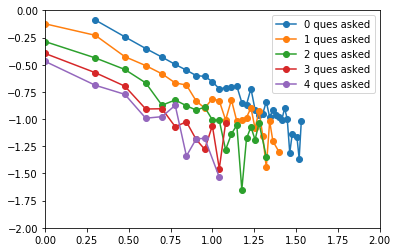

# Answers vs Churn probability


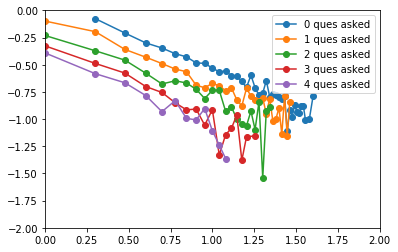

In [40]:
# Figure 3: # Answers vs Churn probability
#    The probability of churning for a user decreases the more answers s/he provides.
#    It is even lower if s/he asks more questions alongside.
min_num_users = 50
for T in list_of_T:
    task2 = features_of_task2[T]
    for num_que_ask in range(5):
        subgroup = task2[task2['num_questions'] == num_que_ask]
        churn_probs = []
        num_answers = list(set(subgroup['num_answers']))
        num_answers.sort()
        for num_ans in num_answers:
            subsubgroup = subgroup[subgroup['num_answers'] == num_ans]
            prob = sum(subsubgroup['is_churn']) / subsubgroup.shape[0]
            if subsubgroup.shape[0] >= min_num_users:
                churn_probs.append((num_ans, prob))

        plt.plot([np.log10(x[0]+1) for x in churn_probs],
                 [np.log10(x[1]+0.01) for x in churn_probs],
                 '-o',
                 label='{} ques asked'.format(num_que_ask))
    print("# Answers vs Churn probability")
    plt.legend()
    plt.axis((0,2,-2,0))
    plt.show()

3-3. Knowledge features

In [0]:
# ### Load pickes of feature class 1, 2
# list_of_K = range(1, 21)
# features_of_task1 = {}
# for K in list_of_K:
#     features_of_task1[K] = pd.read_pickle("data/task1_{}posts_features.pkl".format(K))

# list_of_T = [7, 15, 30]
# features_of_task2 = {}
# for T in list_of_T:
#     features_of_task2[T] = pd.read_pickle("data/task2_{}days_features.pkl".format(T))

# display(features_of_task1[20].head())
# display(features_of_task2[30].head())

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask1(users, posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]

    qnta = all_answers.set_index('ParentId')\
        .join(questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    tqna = answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    return answers, questions, qnta, tqna

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask2(users, posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    qna = answers\
        .set_index('ParentId').join(questions, how='inner',\
                                    lsuffix='A', rsuffix='Q')
    return answers, questions, qna, qna

In [0]:
# Knowledge features 1: accepted_answerer_rep
def getRepOfAcceptedAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta[qnta['AcceptedAnswerIdQ'] == qnta['IdA']]\
        .set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 2: max_rep_answerer 
def getMaxRepAmongAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_max_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].max()
    return rep_max_ans


In [0]:
# Knowledge features 3: num_que_answered
def getNumQueAnswered(users, answers, questions, qnta, tqna):
    # number of questions posted by the user that got answered
    #questions = posts[posts['PostTypeId'] == 1]
    answered_questions = questions[questions['AnswerCount'] > 0]
    return answered_questions.groupby('OwnerUserId')['AnswerCount'].count()


In [0]:
# Knowledge features 4: time_for_first_ans
def getTimeForFirstAns(users, answers, questions, qnta, tqna):
    tmp =  qnta[qnta['CreationDateQ'] < qnta['CreationDateA']]
    tmp['time_for_ans'] = (tmp['CreationDateA'] - tmp['CreationDateQ']).dt.total_seconds() / 60
    questions['time_for_first_ans'] = tmp.groupby(by=tmp.index)['time_for_ans'].min()
    return questions.groupby('OwnerUserId')['time_for_first_ans'].mean()


In [0]:
# Knowledge features 5: rep_questioner
def getAvgRepOfQuestioner(users, answers, questions, qnta, tqna):
    # Avg. reputation of the user whose question was answered
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = tqna.set_index('OwnerUserIdQ')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdA')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 6: rep_answerers
def getAvgRepOfAnswerer(users, answers, questions, qnta, tqna):
    # Avg. reputation of the users who answered the question
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 7: rep_co_answerers
def getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]    
    rep_ans = answers.set_index('OwnerUserId')\
        .join(reputations, how='inner')\
        .set_index('ParentId')\
        .join(questions, how='inner', lsuffix='A', rsuffix='Q')
    avg_rep_ans = rep_ans.groupby(by=rep_ans.index)['Reputation'].mean()
    rep_co_answerer = answers.set_index('ParentId')\
        .join(avg_rep_ans, how='inner')\
        .set_index('OwnerUserId')
    return rep_co_answerer.groupby(by=rep_co_answerer.index)['Reputation'].mean()


In [0]:
# Knowledge features 8: num_answers_recvd
def getAvgNumAnsReceived(users, answers, questions, qnta, tqna):
    #questions = posts[posts['PostTypeId'] == 1]
    return questions.fillna({'AnswerCount': 0}).groupby('OwnerUserId')['AnswerCount'].mean()


In [52]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions, qnta, tqna = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
    features_of_task1[K]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['num_que_answered'] = getNumQueAnswered(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qnta, tqna)

Extract knowledge features of task1(K= 1 )
Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )


In [53]:
for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions, qna, qna1 = preprocessForKnowledgeFeaturesForTask2(users, posts)
    features_of_task2[T]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_que_answered'] = getNumQueAnswered(users, answers, questions, qna, qna1)
    features_of_task2[T]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qna, qna1)

Extract knowledge features of task2(T=) 7 )
Extract knowledge features of task2(T=) 15 )
Extract knowledge features of task2(T=) 30 )


In [54]:
display('features_of_task1[20]:', features_of_task1[20].head())
display('features_of_task2[30]:', features_of_task2[30].head())

'features_of_task1[20]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,gap2,gap3,gap4,gap5,gap6,gap7,gap8,gap9,gap10,gap11,gap12,gap13,gap14,gap15,gap16,gap17,gap18,gap19,gap20,num_answers,num_questions,ans_que_ratio,accepted_answerer_rep,max_rep_answerer,num_que_answered,time_for_first_ans,rep_questioner,rep_answerers,rep_co_answerers,num_answers_recvd
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0,0.0,6.236160e+07,13871.641383,0.000000,1212.879667,738.295283,0.000000,3821.372833,0.000000,446.409433,0.000000,30909.906500,0.000000,6338.125283,2520.863217,0.249617,0.450050,0.564450,0.104550,0.208233,0.679933,0.0,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0,0.0,3.350846e+04,14.637067,1.055600,4488.440233,105.914000,213.653000,8664.172717,2094.917667,306.937167,268.860450,3.240600,1090.866950,14.210383,243.079450,163.205617,348.912383,907.278667,3.568500,3.356383,630.739500,17.0,3.0,4.500000,NaN,NaN,3.0,NaN,53446.0,NaN,55779.0,67.666664
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0,0.0,3.178287e+05,963.251067,18479.137883,14094.074217,2354.710283,887.694667,22378.701500,31136.498217,54922.305567,1466.621767,7.396783,2751.420833,67935.440000,10076.188950,47.300550,2298.722167,45.351833,2069.401117,2602.263883,300.081167,17.0,3.0,4.500000,NaN,NaN,3.0,NaN,39678.8,NaN,NaN,3.666667
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0,0.0,1.316662e+06,6231.270117,1069.794717,6.940950,262.458550,682.875667,1481.491500,2221.188050,2971.120117,28257.784883,2227.568950,904.651550,70.010450,4454.531500,5747.542333,11599.646050,47197.588500,16359.198733,26448.735667,3808.643217,18.0,2.0,6.333333,NaN,NaN,2.0,NaN,2079.0,NaN,NaN,6.500000
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,322.0,0.0,1.402711e+05,4299.353500,2448.063883,1243.589000,7.128450,47.845000,114.664383,5.675050,5601.351500,1256.390733,205.077600,49.783333,1678.190117,445.529717,40.191333,15.179400,17.122933,28.284567,867.795000,265.515767,19.0,1.0,10.000000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.000000


'features_of_task2[30]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,last_gap,time_since_last_post,mean_gap,num_answers,num_questions,ans_que_ratio,accepted_answerer_rep,max_rep_answerer,num_que_answered,time_for_first_ans,rep_questioner,rep_answerers,rep_co_answerers,num_answers_recvd
OwnerUserId,,,,,,,,,,,,,,,,,,,,
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,30.0,0.0,33508.456,122.473267,2936.057733,1323.515600,26.0,4.0,5.400000,NaN,NaN,4.0,NaN,53446.000000,NaN,39752.00000,56.250
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283,4.0,0.0,52622.356,25381.910000,12568.666733,7438.573500,1.0,3.0,0.500000,NaN,NaN,3.0,NaN,NaN,NaN,NaN,6.000
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,6.0,0.0,317828.716,887.694667,1123.986617,6129.811353,5.0,1.0,3.000000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.000
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,9.0,0.0,1316661.823,2971.120117,6328.496617,1658.571074,9.0,0.0,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,75.0,0.0,140271.080,63.865383,2484.611900,511.700490,67.0,8.0,7.555556,NaN,NaN,8.0,NaN,67169.333333,NaN,29035.02619,8.375


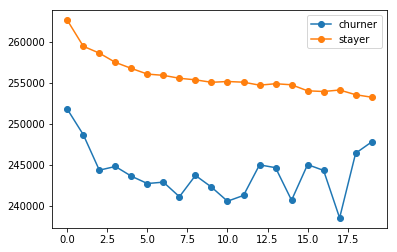

In [55]:
# Figure 4: K vs Time taken for the first answer to arrive
#  The more the time taken for a user to receive an answer, 
#  the lesser the satisfaction level and the more the chances of churning.
churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['time_for_first_ans'] > 0] 
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['time_for_first_ans'] > 0]
    churners_time.append(churners['time_for_first_ans'].mean())
    stayers_time.append(stayers['time_for_first_ans'].mean())

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

In [0]:
# Store until 3-3
for K in list_of_K:
#     store_df_at_google_drive('task1_{}posts_features.csv'.format(K), features_of_task1[K])
    features_of_task1[K].to_pickle('task1_{}posts_features_3_3.pkl'.format(K))
    
for T in list_of_T:
#     store_df_at_google_drive('task2_{}posts_features.csv'.format(T), features_of_task2[T])
    features_of_task2[T].to_pickle('task2_{}days_features_3_3.pkl'.format(T))

In [60]:
### Load
loaded_features_of_task1 = {}
loaded_features_of_task2 = {}
for K in list_of_K:
    loaded_features_of_task1[K] = pd.read_pickle('task1_{}posts_features_3_3.pkl'.format(K))
for T in list_of_T:
    loaded_features_of_task2[T] = pd.read_pickle('task2_{}days_features_3_3.pkl'.format(T))
display('loaded_features_of_task1[20]:', loaded_features_of_task1[20].head())
display('loaded_features_of_task2[30]:', loaded_features_of_task2[30].head())

'loaded_features_of_task1[20]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,gap2,gap3,gap4,gap5,gap6,gap7,gap8,gap9,gap10,gap11,gap12,gap13,gap14,gap15,gap16,gap17,gap18,gap19,gap20,num_answers,num_questions,ans_que_ratio,accepted_answerer_rep,max_rep_answerer,num_que_answered,time_for_first_ans,rep_questioner,rep_answerers,rep_co_answerers,num_answers_recvd
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0,0.0,6.236160e+07,13871.641383,0.000000,1212.879667,738.295283,0.000000,3821.372833,0.000000,446.409433,0.000000,30909.906500,0.000000,6338.125283,2520.863217,0.249617,0.450050,0.564450,0.104550,0.208233,0.679933,0.0,0.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0,0.0,3.350846e+04,14.637067,1.055600,4488.440233,105.914000,213.653000,8664.172717,2094.917667,306.937167,268.860450,3.240600,1090.866950,14.210383,243.079450,163.205617,348.912383,907.278667,3.568500,3.356383,630.739500,17.0,3.0,4.500000,NaN,NaN,3.0,NaN,53446.0,NaN,55779.0,67.666664
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0,0.0,3.178287e+05,963.251067,18479.137883,14094.074217,2354.710283,887.694667,22378.701500,31136.498217,54922.305567,1466.621767,7.396783,2751.420833,67935.440000,10076.188950,47.300550,2298.722167,45.351833,2069.401117,2602.263883,300.081167,17.0,3.0,4.500000,NaN,NaN,3.0,NaN,39678.8,NaN,NaN,3.666667
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0,0.0,1.316662e+06,6231.270117,1069.794717,6.940950,262.458550,682.875667,1481.491500,2221.188050,2971.120117,28257.784883,2227.568950,904.651550,70.010450,4454.531500,5747.542333,11599.646050,47197.588500,16359.198733,26448.735667,3808.643217,18.0,2.0,6.333333,NaN,NaN,2.0,NaN,2079.0,NaN,NaN,6.500000
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,322.0,0.0,1.402711e+05,4299.353500,2448.063883,1243.589000,7.128450,47.845000,114.664383,5.675050,5601.351500,1256.390733,205.077600,49.783333,1678.190117,445.529717,40.191333,15.179400,17.122933,28.284567,867.795000,265.515767,19.0,1.0,10.000000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,4.000000


'loaded_features_of_task2[30]:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,last_gap,time_since_last_post,mean_gap,num_answers,num_questions,ans_que_ratio,accepted_answerer_rep,max_rep_answerer,num_que_answered,time_for_first_ans,rep_questioner,rep_answerers,rep_co_answerers,num_answers_recvd
OwnerUserId,,,,,,,,,,,,,,,,,,,,
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,30.0,0.0,33508.456,122.473267,2936.057733,1323.515600,26.0,4.0,5.400000,NaN,NaN,4.0,NaN,53446.000000,NaN,39752.00000,56.250
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283,4.0,0.0,52622.356,25381.910000,12568.666733,7438.573500,1.0,3.0,0.500000,NaN,NaN,3.0,NaN,NaN,NaN,NaN,6.000
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,6.0,0.0,317828.716,887.694667,1123.986617,6129.811353,5.0,1.0,3.000000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.000
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,9.0,0.0,1316661.823,2971.120117,6328.496617,1658.571074,9.0,0.0,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,40819,2008-07-31 14:22:31.317,2019-09-01 04:03:18.900,75.0,0.0,140271.080,63.865383,2484.611900,511.700490,67.0,8.0,7.555556,NaN,NaN,8.0,NaN,67169.333333,NaN,29035.02619,8.375


Implement the other features yourself!!

3-4. Speed features

3-5. Quality features

3-6. Consistency features

3-7. Gratitude features

3-8. Competitiveness features

3-9. Content features

In [61]:
user, post = users_of_task1[20], posts_of_task1[20]
display('user:', user.head(3))
display('post:', post.head(3))

'user:'

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,gap2,gap3,gap4,gap5,gap6,gap7,gap8,gap9,gap10,gap11,gap12,gap13,gap14,gap15,gap16,gap17,gap18,gap19,gap20,num_answers,num_questions
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0,0.0,6.236160e+07,13871.641383,0.000000,1212.879667,738.295283,0.000000,3821.372833,0.000000,446.409433,0.000000,30909.906500,0.000000,6338.125283,2520.863217,0.249617,0.450050,0.564450,0.104550,0.208233,0.679933,NaN,NaN
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0,0.0,3.350846e+04,14.637067,1.055600,4488.440233,105.914000,213.653000,8664.172717,2094.917667,306.937167,268.860450,3.240600,1090.866950,14.210383,243.079450,163.205617,348.912383,907.278667,3.568500,3.356383,630.739500,17.0,3.0
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0,0.0,3.178287e+05,963.251067,18479.137883,14094.074217,2354.710283,887.694667,22378.701500,31136.498217,54922.305567,1466.621767,7.396783,2751.420833,67935.440000,10076.188950,47.300550,2298.722167,45.351833,2069.401117,2602.263883,300.081167,17.0,3.0


'post:'

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith
0,3609905,3,NaN,2010-07-22 18:39:58.787,0.0,-1,0.0,0.0,NaN,2008-07-31,48.0,1
1,3625049,3,NaN,2010-08-01 09:51:37.270,0.0,-1,0.0,0.0,NaN,2008-07-31,8.0,2
2,3625050,3,NaN,2010-08-01 09:51:37.270,0.0,-1,0.0,0.0,NaN,2008-07-31,7.0,3


In [62]:
user, post = users_of_task2[30], posts_of_task2[30]
display('user:', user.head(3))
display('post:', post.head(3))
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    users_of_task2[T]['num_answers'] = getNumAnswers(posts)
    users_of_task2[T]['num_questions'] = getNumQuestions(posts)
    users_of_task2[T] = users_of_task2[T].fillna({'num_answers':0, 'num_questions':0})
display('user:', user.head(3))
display('post:', post.head(3))

'user:'

,Reputation,CreationDate,LastAccessDate,num_posts
Id,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283,11.0


'post:'

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith,DataframeIndex
3126,9,1,1404.0,2008-07-31 23:40:59.743,1742.0,1,63.0,5.0,NaN,2008-07-31 14:22:31.287,16.0,1,3126
3127,11,1,1248.0,2008-07-31 23:55:37.967,1444.0,1,37.0,3.0,NaN,2008-07-31 14:22:31.287,23.0,2,3127
3128,12,2,NaN,2008-07-31 23:56:41.303,327.0,1,0.0,11.0,11.0,2008-07-31 14:22:31.287,194.0,3,3128


'user:'

,Reputation,CreationDate,LastAccessDate,num_posts,num_answers,num_questions
Id,,,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0,NaN,NaN
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0,26.0,4.0
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283,11.0,1.0,3.0


'post:'

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith,DataframeIndex
3126,9,1,1404.0,2008-07-31 23:40:59.743,1742.0,1,63.0,5.0,NaN,2008-07-31 14:22:31.287,16.0,1,3126
3127,11,1,1248.0,2008-07-31 23:55:37.967,1444.0,1,37.0,3.0,NaN,2008-07-31 14:22:31.287,23.0,2,3127
3128,12,2,NaN,2008-07-31 23:56:41.303,327.0,1,0.0,11.0,11.0,2008-07-31 14:22:31.287,194.0,3,3128


In [76]:
display(posts_df[posts_df['Id']==12])
display(posts_df[posts_df['ParentId']==11])

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith,DataframeIndex
3128,12,2,NaN,2008-07-31 23:56:41.303,327.0,1,0.0,11.0,11.0,2008-07-31 14:22:31.287,194.0,3,3128


,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith,DataframeIndex
3128,12,2,NaN,2008-07-31 23:56:41.303,327.0,1,0.0,11.0,11.0,2008-07-31 14:22:31.287,194.0,3,3128
5110,27,2,NaN,2008-08-01 12:17:19.357,29.0,17,0.0,0.0,11.0,2008-08-01 12:02:21.617,170.0,2,5110
28224,1248,2,NaN,2008-08-04 13:57:26.097,945.0,268,0.0,19.0,11.0,2008-08-04 10:11:11.637,199.0,3,28224
33426,1752,2,NaN,2008-08-05 00:42:56.853,14.0,332,0.0,0.0,11.0,2008-08-04 17:51:58.197,440.0,3,33426
82079,12279,2,NaN,2008-08-15 14:20:04.133,10.0,987,0.0,0.0,11.0,2008-08-11 12:14:17.010,55.0,31,82079
87584,18393,2,NaN,2008-08-20 17:26:49.357,17.0,1063,0.0,1.0,11.0,2008-08-12 05:40:42.810,173.0,17,87584
96470,10705,2,NaN,2008-08-14 05:43:45.330,92.0,1220,0.0,5.0,11.0,2008-08-13 13:44:48.200,204.0,15,96470
113263,12852,2,NaN,2008-08-15 22:42:33.870,12.0,1472,0.0,0.0,11.0,2008-08-15 18:35:39.190,60.0,1,113263
127222,25709,2,NaN,2008-08-25 06:12:29.623,2.0,1612,0.0,0.0,11.0,2008-08-17 14:52:15.597,94.0,9,127222
270241,118569,2,NaN,2008-09-23 01:09:30.193,8.0,4234,0.0,0.0,11.0,2008-09-02 13:28:31.757,123.0,11,270241


In [0]:
### Test data
users, posts = users_of_task1[20], posts_of_task1[20]
all_posts = posts_df
### Answering questions
answers = posts[posts['PostTypeId'] == 2]
# display('answers: {}'.format(answers.shape), answers.head(3))
### Answer time
answers_time = answers['CreationDate']
### Question time
# all_answers = all_posts[all_posts['PostTypeId'] == 2]
all_questions = all_posts[all_posts['PostTypeId'] == 1]
# display('all_questions: {}'.format(all_questions.shape), all_questions.head(3))
# qnta = all_answers.set_index('ParentId').join(questions, how='inner', lsuffix='A', rsuffix='Q')
# display(qnta.head(3))
tqna = answers.merge(all_questions, how='inner', left_on='ParentId', right_on='Id') # (908425, 25)
# display('tqna: {}'.format(tqna.shape), tqna.head(3))
# display('invalid:', len(tqna[tqna['CreationDate_x'] <= tqna['CreationDate_y']]))
# display('valid:', len(tqna[tqna['CreationDate_x'] > tqna['CreationDate_y']]))
### Speed = answer time - question time
valid_tqna = tqna[tqna['CreationDate_x'] > tqna['CreationDate_y']]
valid_tqna['anwsering_speed'] = (valid_tqna['CreationDate_x'] - valid_tqna['CreationDate_y']).dt.total_seconds() / 60
# display(valid_tqna.head(3))
answers['anwsering_speed'] = valid_tqna['anwsering_speed']
# display(answers)
# questions.groupby('OwnerUserId')['time_for_first_ans'].mean()


'answers: (953486, 12)'

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith
3128,12,2,NaN,2008-07-31 23:56:41.303,327.0,1,0.0,11.0,11.0,2008-07-31 14:22:31.287,194.0,3
3129,986,2,NaN,2008-08-04 02:45:07.717,3.0,1,0.0,0.0,944.0,2008-07-31 14:22:31.287,117.0,4
3130,1016,2,NaN,2008-08-04 04:31:02.557,12.0,1,0.0,0.0,944.0,2008-07-31 14:22:31.287,47.0,5


'all_questions: (3102286, 13)'

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith,DataframeIndex
3126,9,1,1404.0,2008-07-31 23:40:59.743,1742.0,1,63.0,5.0,NaN,2008-07-31 14:22:31.287,16.0,1,3126
3127,11,1,1248.0,2008-07-31 23:55:37.967,1444.0,1,37.0,3.0,NaN,2008-07-31 14:22:31.287,23.0,2,3127
3135,8472,1,8637.0,2008-08-12 04:59:35.017,318.0,1,103.0,25.0,NaN,2008-07-31 14:22:31.287,180.0,10,3135


'tqna: (908425, 25)'

,Id_x,PostTypeId_x,AcceptedAnswerId_x,CreationDate_x,Score_x,OwnerUserId_x,AnswerCount_x,CommentCount_x,ParentId_x,CreationDateOfOwner_x,...,CreationDate_y,Score_y,OwnerUserId_y,AnswerCount_y,CommentCount_y,ParentId_y,CreationDateOfOwner_y,BodyWordNum_y,ith_y,DataframeIndex
0,12,2,NaN,2008-07-31 23:56:41.303,327.0,1,0.0,11.0,11.0,2008-07-31 14:22:31.287,...,2008-07-31 23:55:37.967,1444.0,1,37.0,3.0,NaN,2008-07-31 14:22:31.287,23.0,2,3127
1,27,2,NaN,2008-08-01 12:17:19.357,29.0,17,0.0,0.0,11.0,2008-08-01 12:02:21.617,...,2008-07-31 23:55:37.967,1444.0,1,37.0,3.0,NaN,2008-07-31 14:22:31.287,23.0,2,3127
2,1248,2,NaN,2008-08-04 13:57:26.097,945.0,268,0.0,19.0,11.0,2008-08-04 10:11:11.637,...,2008-07-31 23:55:37.967,1444.0,1,37.0,3.0,NaN,2008-07-31 14:22:31.287,23.0,2,3127


'invalid:'

153

'valid:'

908272

Extract knowledge features of task1(K= 1 )
Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )
Extract knowledge features of task2(T=) 7 )
Extract knowledge features of task2(T=) 15 )
Extract knowledge features of task2(T=) 

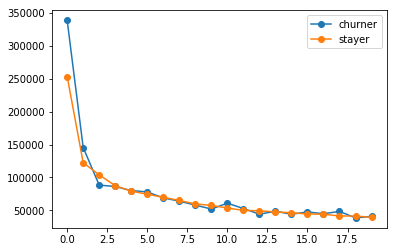

In [80]:
### 3-4. Speed features
### Speed features represent
###   how quick a user is in responding to another user's question.
###   This is an indirect measure of the user's enthusiasm and 
###   intuitively negatively correlates with user churn.
### answering speed: Inverse of the time gap between a
###   question being posted and the user answering it.
###
### PostTypeId==1(Q) => Id answered by AcceptedAnswerId
### PostTypeId==2(A) => Id answering ParentId
def preprocessForSpeedFeaturesForTask1(posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]
    tqna = answers.merge(all_questions, how='inner', left_on='ParentId', right_on='Id') # (908425, 25)
    return answers, tqna

preprocessForSpeedFeaturesForTask2 = preprocessForSpeedFeaturesForTask1

def getAnsweringSpeed(answers, tqna):
    ### Speed = answer time - question time
    valid_tqna = tqna[tqna['CreationDate_x'] > tqna['CreationDate_y']]
    valid_tqna['answering_speed'] = (valid_tqna['CreationDate_x'] - valid_tqna['CreationDate_y']).dt.total_seconds() / 60
    answers['answering_speed'] = valid_tqna['answering_speed']
    return answers.groupby('OwnerUserId')['answering_speed'].mean()

for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, tqna = preprocessForSpeedFeaturesForTask1(posts, posts_df)
    features_of_task1[K]['answering_speed'] = getAnsweringSpeed(answers, tqna)

for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, tqna = preprocessForSpeedFeaturesForTask2(posts, posts_df)
    features_of_task2[T]['answering_speed'] = getAnsweringSpeed(answers, tqna)

churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['answering_speed'] > 0] 
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['answering_speed'] > 0]
    churners_time.append(churners['answering_speed'].mean())
    stayers_time.append(stayers['answering_speed'].mean())

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

In [104]:
user, post = users_of_task1[20].iloc[0], posts_of_task1[20].iloc[0]
display('users_of_task1[20]:', user)
display('posts_of_task1[20]:', post)
display('features_of_task1[20].iloc[0]:', features_of_task1[20].iloc[0])

'users_of_task1[20]:'

Reputation                                 1
CreationDate             2008-07-31 00:00:00
LastAccessDate    2008-08-26 00:16:53.810000
num_posts                               3126
is_churn                                   0
gap1                             6.23616e+07
gap2                                 13871.6
gap3                                       0
gap4                                 1212.88
gap5                                 738.295
gap6                                       0
gap7                                 3821.37
gap8                                       0
gap9                                 446.409
gap10                                      0
gap11                                30909.9
gap12                                      0
gap13                                6338.13
gap14                                2520.86
gap15                               0.249617
gap16                                0.45005
gap17                                0.56445
gap18     

'posts_of_task1[20]:'

Id                                        3609905
PostTypeId                                      3
AcceptedAnswerId                              NaN
CreationDate           2010-07-22 18:39:58.787000
Score                                           0
OwnerUserId                                    -1
AnswerCount                                     0
CommentCount                                    0
ParentId                                      NaN
CreationDateOfOwner           2008-07-31 00:00:00
BodyWordNum                                    48
ith                                             1
Name: 0, dtype: object

'features_of_task1[20].iloc[0]:'

Reputation                                        1
CreationDate                    2008-07-31 00:00:00
LastAccessDate           2008-08-26 00:16:53.810000
num_posts                                      3126
is_churn                                          0
gap1                                    6.23616e+07
gap2                                        13871.6
gap3                                              0
gap4                                        1212.88
gap5                                        738.295
gap6                                              0
gap7                                        3821.37
gap8                                              0
gap9                                        446.409
gap10                                             0
gap11                                       30909.9
gap12                                             0
gap13                                       6338.13
gap14                                       2520.86
gap15       

In [79]:
user, post = users_of_task2[30].iloc[0], posts_of_task2[30].iloc[0]
display('users_of_task2[30]:', user)
display('posts_of_task2[30]:', post)

'users_of_task2[30]:'

Reputation                                 1
CreationDate             2008-07-31 00:00:00
LastAccessDate    2008-08-26 00:16:53.810000
num_posts                               3126
num_answers                                0
num_questions                              0
Name: -1, dtype: object

'posts_of_task2[30]:'

Id                                              9
PostTypeId                                      1
AcceptedAnswerId                             1404
CreationDate           2008-07-31 23:40:59.743000
Score                                        1742
OwnerUserId                                     1
AnswerCount                                    63
CommentCount                                    5
ParentId                                      NaN
CreationDateOfOwner    2008-07-31 14:22:31.287000
BodyWordNum                                    16
ith                                             1
DataframeIndex                               3126
Name: 3126, dtype: object

Extract knowledge features of task1(K= 1 )
Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )
Extract knowledge features of task2(T= 7 )
Extract knowledge features of task2(T= 15 )
Extract knowledge features of task2(T= 30 

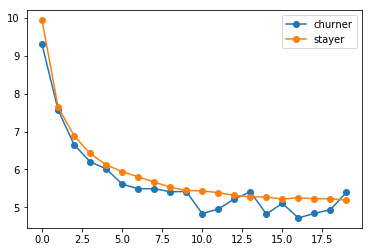

In [105]:
### 3-5. Quality features
### Quality features capture the quality of a user's posts,
###   as reflected by the reputation/reward scores they receive for those posts.
### ans_score: Reputation score obtained per answer given
### que_score: Reputation score obtained per question asked###
def preprocessForQualityFeaturesForTask1(posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    return answers, questions

preprocessForQualityFeaturesForTask2 = preprocessForQualityFeaturesForTask1

def getAnswerScore(answers):
    ### Answer score = questions.Score
    ans_score = answers.groupby('OwnerUserId')['Score'].mean()
    return ans_score

def getQuestionScore(questions):
    ### Question score = answers.Score
    que_score = questions.groupby('OwnerUserId')['Score'].mean()
    return que_score

for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions = preprocessForQualityFeaturesForTask1(posts)
    features_of_task1[K]['ans_score'] = getAnswerScore(answers)
    features_of_task1[K]['que_score'] = getQuestionScore(questions)

for T in list_of_T:
    print("Extract knowledge features of task2(T=",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions = preprocessForQualityFeaturesForTask2(posts)
    features_of_task2[T]['ans_score'] = getAnswerScore(answers)
    features_of_task2[T]['que_score'] = getQuestionScore(questions)

churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['ans_score'] > 0] 
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['ans_score'] > 0]
    churners_time.append(churners['ans_score'].mean())
    stayers_time.append(stayers['ans_score'].mean())

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

In [0]:
### 3-6. Consistency features

### 3-7. Gratitude features

### 3-8. Competitiveness features

### 3-9. Content features

Extract knowledge features of task1 ( K= 1 )
Extract knowledge features of task1 ( K= 2 )
Extract knowledge features of task1 ( K= 3 )
Extract knowledge features of task1 ( K= 4 )
Extract knowledge features of task1 ( K= 5 )
Extract knowledge features of task1 ( K= 6 )
Extract knowledge features of task1 ( K= 7 )
Extract knowledge features of task1 ( K= 8 )
Extract knowledge features of task1 ( K= 9 )
Extract knowledge features of task1 ( K= 10 )
Extract knowledge features of task1 ( K= 11 )
Extract knowledge features of task1 ( K= 12 )
Extract knowledge features of task1 ( K= 13 )
Extract knowledge features of task1 ( K= 14 )
Extract knowledge features of task1 ( K= 15 )
Extract knowledge features of task1 ( K= 16 )
Extract knowledge features of task1 ( K= 17 )
Extract knowledge features of task1 ( K= 18 )
Extract knowledge features of task1 ( K= 19 )
Extract knowledge features of task1 ( K= 20 )
Extract knowledge features of task2 ( T= 7 )
Extract knowledge features of task2 ( T= 15 

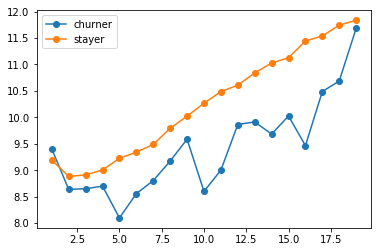

In [106]:
### 3-6. Consistency features
### Consistency features capture the consistency in quality of posts.
###   Our insight is: the more consistent a user's posts are,
###   the lower the chances of their churning.
### ans stddev: Standard deviation of the reputation scores obtained for the answers
### que stddev: Standard deviation of the reputation scores obtained for the questions
def preprocessForConsistencyFeaturesForTask1(posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    return answers, questions

preprocessForConsistencyFeaturesForTask2 = preprocessForConsistencyFeaturesForTask1

def getAnswerConsistency(answers):
    ### Answer score = questions.Score
    ans_stddev = answers.groupby('OwnerUserId')['Score'].std()
    return ans_stddev

def getQuestionConsistency(questions):
    ### Question score = answers.Score
    que_stddev = questions.groupby('OwnerUserId')['Score'].std()
    return que_stddev

for K in list_of_K:
    print("Extract knowledge features of task1 ( K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions = preprocessForConsistencyFeaturesForTask1(posts)
    features_of_task1[K]['ans_stddev'] = getAnswerConsistency(answers)
    features_of_task1[K]['que_stddev'] = getQuestionConsistency(questions)

for T in list_of_T:
    print("Extract knowledge features of task2 ( T=",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions = preprocessForConsistencyFeaturesForTask2(posts)
    features_of_task2[T]['ans_stddev'] = getAnswerConsistency(answers)
    features_of_task2[T]['que_stddev'] = getQuestionConsistency(questions)

churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['ans_stddev'] > 0]
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['ans_stddev'] > 0]
    churners_time.append(churners['ans_stddev'].mean())
    stayers_time.append(stayers['ans_stddev'].mean())

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

Extract knowledge features of task1 ( K= 1 )
Extract knowledge features of task1 ( K= 2 )
Extract knowledge features of task1 ( K= 3 )
Extract knowledge features of task1 ( K= 4 )
Extract knowledge features of task1 ( K= 5 )
Extract knowledge features of task1 ( K= 6 )
Extract knowledge features of task1 ( K= 7 )
Extract knowledge features of task1 ( K= 8 )
Extract knowledge features of task1 ( K= 9 )
Extract knowledge features of task1 ( K= 10 )
Extract knowledge features of task1 ( K= 11 )
Extract knowledge features of task1 ( K= 12 )
Extract knowledge features of task1 ( K= 13 )
Extract knowledge features of task1 ( K= 14 )
Extract knowledge features of task1 ( K= 15 )
Extract knowledge features of task1 ( K= 16 )
Extract knowledge features of task1 ( K= 17 )
Extract knowledge features of task1 ( K= 18 )
Extract knowledge features of task1 ( K= 19 )
Extract knowledge features of task1 ( K= 20 )
Extract knowledge features of task2 ( T= 7 )
Extract knowledge features of task2 ( T= 15 

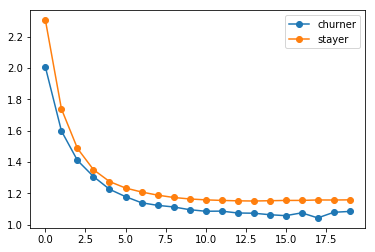

In [107]:
### 3-7. Gratitude features
### Gratitude features represent how other users explicitly express gratitude
###   on the user's posts. Intuitively, this is one of the measures 
###   of user's gratification and hence correlates negatively with churn.
### ans comments: Average #comments made on the user's answer
### que comments: Average #comments made on the user's question
def preprocessForGratitudeFeaturesForTask1(posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    return answers, questions

preprocessForGratitudeFeaturesForTask2 = preprocessForGratitudeFeaturesForTask1

def getAnswerGratitude(answers):
    ### Answer score = questions.Score
    ans_comments = answers.groupby('OwnerUserId')['CommentCount'].mean()
    return ans_comments

def getQuestionGratitude(questions):
    ### Question score = answers.Score
    que_comments = questions.groupby('OwnerUserId')['CommentCount'].mean()
    return que_comments

for K in list_of_K:
    print("Extract knowledge features of task1 ( K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions = preprocessForGratitudeFeaturesForTask1(posts)
    features_of_task1[K]['ans_comments'] = getAnswerGratitude(answers)
    features_of_task1[K]['que_comments'] = getQuestionGratitude(questions)

for T in list_of_T:
    print("Extract knowledge features of task2 ( T=",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions = preprocessForGratitudeFeaturesForTask2(posts)
    features_of_task2[T]['ans_comments'] = getAnswerGratitude(answers)
    features_of_task2[T]['que_comments'] = getQuestionGratitude(questions)

churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['ans_comments'] > 0]
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['ans_comments'] > 0]
    churners_time.append(churners['ans_comments'].mean())
    stayers_time.append(stayers['ans_comments'].mean())

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

In [108]:
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

print(users_of_task1[20].head(3))
# posts_df.set_index('index', inplace=True)
print(posts_of_task1[20].head(3))

    Reputation            CreationDate          LastAccessDate  num_posts  is_churn          gap1          gap2          gap3          gap4         gap5        gap6          gap7          gap8          gap9        gap10         gap11        gap12         gap13         gap14       gap15        gap16       gap17        gap18        gap19       gap20  num_answers  num_questions
Id                                                                                                                                                                                                                                                                                                                                                                                       
-1           1 2008-07-31 00:00:00.000 2008-08-26 00:16:53.810     3126.0       0.0  6.236160e+07  13871.641383      0.000000   1212.879667   738.295283    0.000000   3821.372833      0.000000    446.409433     0.000000  30909.906500     0.0000

In [0]:
### Test data
users, posts = users_of_task1[20], posts_of_task1[20]
display(users.sort_values('num_answers').head(3))
tmp = users.sort_values('num_answers').reset_index() # copy by value
display(tmp.head(3))
tmp['rank_answer'] = tmp.index
tmp.set_index('Id', inplace=True)
display(tmp.head(3))
rank_answer = tmp['rank_answer']
display(rank_answer.head(3))

,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,gap2,gap3,gap4,gap5,gap6,gap7,gap8,gap9,gap10,gap11,gap12,gap13,gap14,gap15,gap16,gap17,gap18,gap19,gap20,num_answers,num_questions
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
85116,2062,2009-03-31 14:02:32.547,2015-08-07 15:10:25.357,38.0,0.0,634.716,13079.956500,2708.833950,18707.483333,14477.692550,551.731450,2402.117950,1335.651167,3095.442833,4070.122833,29111.196217,60238.188383,187170.247900,68193.561717,17236.819383,54433.882067,221.162333,27205.357767,30381.922450,111964.465617,1.0,19.0
686800,452,2011-04-01 01:37:24.367,2016-02-03 21:10:59.587,39.0,0.0,429.763,10395.383950,14340.342500,11423.806933,1390.523500,1438.630567,6074.318500,1386.920500,11241.161500,7201.666167,230.145600,1349.471000,2972.756950,1228.154950,4323.129933,2845.212167,1831.217400,1075.367333,212.367833,5788.621050,1.0,19.0
687554,1565,2011-04-01 12:21:08.607,2019-07-31 03:11:48.740,20.0,1.0,2386.173,233.866617,181.349433,2706.731783,152.845333,5618.585167,1414.000667,4190.162450,2004.369667,3705.679050,3127.531667,2552.680383,950.447833,2114.723900,1402.211217,205.535333,4153.900167,142.510617,1662.055050,1173.627383,1.0,19.0


,Id,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,gap2,gap3,gap4,gap5,gap6,gap7,gap8,gap9,gap10,gap11,gap12,gap13,gap14,gap15,gap16,gap17,gap18,gap19,gap20,num_answers,num_questions
0,85116,2062,2009-03-31 14:02:32.547,2015-08-07 15:10:25.357,38.0,0.0,634.716,13079.956500,2708.833950,18707.483333,14477.692550,551.731450,2402.117950,1335.651167,3095.442833,4070.122833,29111.196217,60238.188383,187170.247900,68193.561717,17236.819383,54433.882067,221.162333,27205.357767,30381.922450,111964.465617,1.0,19.0
1,686800,452,2011-04-01 01:37:24.367,2016-02-03 21:10:59.587,39.0,0.0,429.763,10395.383950,14340.342500,11423.806933,1390.523500,1438.630567,6074.318500,1386.920500,11241.161500,7201.666167,230.145600,1349.471000,2972.756950,1228.154950,4323.129933,2845.212167,1831.217400,1075.367333,212.367833,5788.621050,1.0,19.0
2,687554,1565,2011-04-01 12:21:08.607,2019-07-31 03:11:48.740,20.0,1.0,2386.173,233.866617,181.349433,2706.731783,152.845333,5618.585167,1414.000667,4190.162450,2004.369667,3705.679050,3127.531667,2552.680383,950.447833,2114.723900,1402.211217,205.535333,4153.900167,142.510617,1662.055050,1173.627383,1.0,19.0


,Reputation,CreationDate,LastAccessDate,num_posts,is_churn,gap1,gap2,gap3,gap4,gap5,gap6,gap7,gap8,gap9,gap10,gap11,gap12,gap13,gap14,gap15,gap16,gap17,gap18,gap19,gap20,num_answers,num_questions,rank_answer
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
85116,2062,2009-03-31 14:02:32.547,2015-08-07 15:10:25.357,38.0,0.0,634.716,13079.956500,2708.833950,18707.483333,14477.692550,551.731450,2402.117950,1335.651167,3095.442833,4070.122833,29111.196217,60238.188383,187170.247900,68193.561717,17236.819383,54433.882067,221.162333,27205.357767,30381.922450,111964.465617,1.0,19.0,0
686800,452,2011-04-01 01:37:24.367,2016-02-03 21:10:59.587,39.0,0.0,429.763,10395.383950,14340.342500,11423.806933,1390.523500,1438.630567,6074.318500,1386.920500,11241.161500,7201.666167,230.145600,1349.471000,2972.756950,1228.154950,4323.129933,2845.212167,1831.217400,1075.367333,212.367833,5788.621050,1.0,19.0,1
687554,1565,2011-04-01 12:21:08.607,2019-07-31 03:11:48.740,20.0,1.0,2386.173,233.866617,181.349433,2706.731783,152.845333,5618.585167,1414.000667,4190.162450,2004.369667,3705.679050,3127.531667,2552.680383,950.447833,2114.723900,1402.211217,205.535333,4153.900167,142.510617,1662.055050,1173.627383,1.0,19.0,2


Id
85116     0
686800    1
687554    2
Name: rank_answer, dtype: int64

Extract knowledge features of task1 ( K = 1 )
Extract knowledge features of task1 ( K = 2 )
Extract knowledge features of task1 ( K = 3 )
Extract knowledge features of task1 ( K = 4 )
Extract knowledge features of task1 ( K = 5 )
Extract knowledge features of task1 ( K = 6 )
Extract knowledge features of task1 ( K = 7 )
Extract knowledge features of task1 ( K = 8 )
Extract knowledge features of task1 ( K = 9 )
Extract knowledge features of task1 ( K = 10 )
Extract knowledge features of task1 ( K = 11 )
Extract knowledge features of task1 ( K = 12 )
Extract knowledge features of task1 ( K = 13 )
Extract knowledge features of task1 ( K = 14 )
Extract knowledge features of task1 ( K = 15 )
Extract knowledge features of task1 ( K = 16 )
Extract knowledge features of task1 ( K = 17 )
Extract knowledge features of task1 ( K = 18 )
Extract knowledge features of task1 ( K = 19 )
Extract knowledge features of task1 ( K = 20 )
Extract knowledge features of task2 ( T = 7 )
Extract knowledge featu

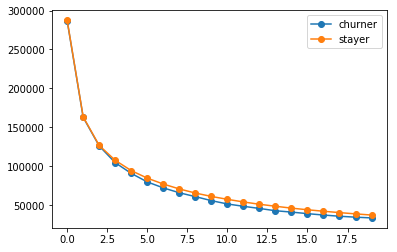

In [109]:
### 3-8. Competitiveness features
### Competitiveness features capture the user's will to provide higher quality answers
###   when compared to other peers who answer the same question.
###   We believe that the gratification obtained from an answer depends
###   not only on the user's answer but also on the (number of) answers other users have provided.
### relative_rank_pos: Average of total number of answers
###   for a question divided by the rank of user's answer
def getAnswerCompetitiveness(users):
    ### users: index = 'Id' (= OwnerUserId)
    tmp = users.sort_values('num_answers').reset_index() # copy by value
    tmp['relative_rank_pos'] = tmp.index
    tmp.set_index('Id', inplace=True)
    relative_rank_pos = tmp['relative_rank_pos']
    return relative_rank_pos

for K in list_of_K:
    print("Extract knowledge features of task1 ( K =",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['relative_rank_pos'] = getAnswerCompetitiveness(users)

for T in list_of_T:
    print("Extract knowledge features of task2 ( T =",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['relative_rank_pos'] = getAnswerCompetitiveness(users)

churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['relative_rank_pos'] > 0]
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['relative_rank_pos'] > 0]
    churners_time.append(churners['relative_rank_pos'].mean())
    stayers_time.append(stayers['relative_rank_pos'].mean())

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

Extract knowledge features of task1 ( K= 1 )
Extract knowledge features of task1 ( K= 2 )
Extract knowledge features of task1 ( K= 3 )
Extract knowledge features of task1 ( K= 4 )
Extract knowledge features of task1 ( K= 5 )
Extract knowledge features of task1 ( K= 6 )
Extract knowledge features of task1 ( K= 7 )
Extract knowledge features of task1 ( K= 8 )
Extract knowledge features of task1 ( K= 9 )
Extract knowledge features of task1 ( K= 10 )
Extract knowledge features of task1 ( K= 11 )
Extract knowledge features of task1 ( K= 12 )
Extract knowledge features of task1 ( K= 13 )
Extract knowledge features of task1 ( K= 14 )
Extract knowledge features of task1 ( K= 15 )
Extract knowledge features of task1 ( K= 16 )
Extract knowledge features of task1 ( K= 17 )
Extract knowledge features of task1 ( K= 18 )
Extract knowledge features of task1 ( K= 19 )
Extract knowledge features of task1 ( K= 20 )
Extract knowledge features of task2 ( T= 7 )
Extract knowledge features of task2 ( T= 15 

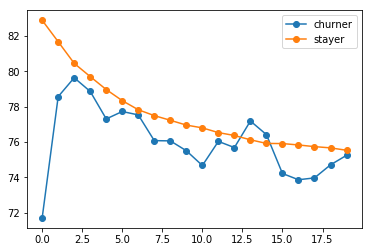

In [110]:
### 3-9. Content features
### Content features use the content of the posts, 
###   and are based on the observation [18] that at k=1, 
###   longer questions correlate with lower chance of churning.
### ans length: Average length of an answer
### que length: Average length of a question
def preprocessForContentFeaturesForTask1(posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    return answers, questions

preprocessForContentFeaturesForTask2 = preprocessForContentFeaturesForTask1

def getAnswerContent(answers):
    ### Answer score = questions.Score
    ans_length = answers.groupby('OwnerUserId')['BodyWordNum'].mean()
    return ans_length

def getQuestionContent(questions):
    ### Question score = answers.Score
    que_length = questions.groupby('OwnerUserId')['BodyWordNum'].mean()
    return que_length

for K in list_of_K:
    print("Extract knowledge features of task1 ( K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions = preprocessForContentFeaturesForTask1(posts)
    features_of_task1[K]['ans_length'] = getAnswerContent(answers)
    features_of_task1[K]['que_length'] = getQuestionContent(questions)

for T in list_of_T:
    print("Extract knowledge features of task2 ( T=",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions = preprocessForContentFeaturesForTask2(posts)
    features_of_task2[T]['ans_length'] = getAnswerContent(answers)
    features_of_task2[T]['que_length'] = getQuestionContent(questions)

churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['ans_length'] > 0]
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['ans_length'] > 0]
    churners_time.append(churners['ans_length'].mean())
    stayers_time.append(stayers['ans_length'].mean())

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

In [0]:
# ### Load pickes of feature class 1, 2
# list_of_K = range(1, 21)
# for K in list_of_K:
#     features_of_task1[K] = pd.read_pickle("data/task1_{}posts_features.pkl".format(K))

# list_of_T = [7, 15, 30]
# features_of_task2 = {}
# for T in list_of_T:
#     features_of_task2[T] = pd.read_pickle("data/task2_{}days_features.pkl".format(T))

# display(features_of_task1[20].head())
# display(features_of_task2[30].head())

,gap1,gap2,gap3,gap4,gap5,gap6,gap7,gap8,gap9,gap10,...,gap15,gap16,gap17,gap18,gap19,gap20,num_answers,num_questions,ans_que_ratio,is_churn
OwnerUserId,,,,,,,,,,,,,,,,,,,,,
1,558.474267,14.637067,1.055600,4488.440233,105.914000,213.653000,8664.172717,2094.917667,306.937167,268.860450,...,163.205617,348.912383,907.278667,3.568500,3.356383,630.739500,1.0,2.0,0.666667,0.0
3,5297.145267,963.251067,18479.137883,14094.074217,2354.710283,887.694667,22378.701500,31136.498217,54922.305567,1466.621767,...,47.300550,2298.722167,45.351833,2069.401117,2602.263883,300.081167,1.0,0.0,2.000000,0.0
4,21944.363717,6231.270117,1069.794717,6.940950,262.458550,682.875667,1481.491500,2221.188050,2971.120117,28257.784883,...,5747.542333,11599.646050,47197.588500,16359.198733,26448.735667,3808.643217,1.0,0.0,2.000000,0.0
5,2337.851333,4299.353500,2448.063883,1243.589000,7.128450,47.845000,114.664383,5.675050,5601.351500,1256.390733,...,40.191333,15.179400,17.122933,28.284567,867.795000,265.515767,1.0,0.0,2.000000,0.0
9,32.701717,9.821050,144.683667,1025.263733,7914.603383,11216.584283,1409.294167,7086.794883,1863.017783,1066.975267,...,65.633333,63.436900,6.793000,1148.970217,56165.940450,40.239667,1.0,2.0,0.666667,0.0


,is_churn,gap1,last_gap,time_since_last_post,mean_gap,num_answers,num_questions,num_posts,ans_que_ratio
OwnerUserId,,,,,,,,,
1,0.0,558.474267,122.473267,2936.0,1323.515600,26.0,4.0,30.0,5.400000
2,0.0,877.039267,25381.910000,12568.0,7438.573500,1.0,3.0,4.0,0.500000
3,0.0,5297.145267,887.694667,1123.0,6129.811353,5.0,1.0,6.0,3.000000
4,0.0,21944.363717,2971.120117,6328.0,1658.571074,0.0,0.0,0.0,10.000000
5,0.0,2337.851333,63.865383,2484.0,511.700490,67.0,8.0,75.0,7.555556


5. Train models for each tasks with the features

    1. Decision Tree
    2. SVM (Linear)
    3. SVM (RBF)
    4. Logistic Regression

In [0]:
def fill_nan(features):
    # ~.sum(axis=0) is true => there is nan in 'time_for_first_ans'
    if 'time_for_first_ans' in features.columns and np.isnan(features['time_for_first_ans']).sum(0):
        features['time_for_first_ans'] = 1 / features['time_for_first_ans']
        features['time_for_first_ans'] = features['time_for_first_ans'].replace([np.nan], 0)
    fill_constants = {
        'accepted_answerer_rep': 0,
        'max_rep_answerer': 0,
        'num_que_answered': 0, 
        'rep_questioner': 0,
        'rep_answerers': 0,
        'rep_co_answerers': 0,
        'num_answers_recvd': 0,
        'answering_speed': 0,
        'ans_score': 0,
        'que_score': 0,
        'ans_stddev': 0,
        'que_stddev': 0,
        'ans_comments': 0,
        'que_comments': 0,
        'relative_rank_pos': 0,
        'ans_length': 0,
        'que_length': 0,
    }
    return features.fillna(fill_constants)
                                                                         

In [0]:
for K in list_of_K:
#     print("Fill NaN of task1(K=",K,")")
    features_of_task1[K] = fill_nan(features_of_task1[K])
    # features_of_task1[K].drop(['answering_speed'], axis=1, inplace=True)
    num_nan = features_of_task1[K].isnull().sum().sum()
    if num_nan > 0:
      display('{} NANs in features_of_task1[{}]'.format(num_nan, K))


In [0]:
for T in list_of_T:
#     print("Fill NaN of task2(T=)",T,")")
    features_of_task2[T] = fill_nan(features_of_task2[T])
    # features_of_task2[T].drop(['answering_speed'], axis=1, inplace=True)
    num_nan = features_of_task2[T].isnull().sum().sum()
    if num_nan > 0:
      display('{} NANs in features_of_task2[{}]'.format(num_nan, T))


In [0]:
# Store the whole features of task1 to Google Drive
for K in list_of_K:
#     store_df_at_google_drive('task1_{}posts_features.csv'.format(K), features_of_task1[K])
    features_of_task1[K].to_pickle('task1_{}posts_features_3_9.pkl'.format(K))
    # features_of_task1[K].to_csv('data/3-9/task1_{}posts_important_features.csv'.format(K))

In [0]:
for T in list_of_T:
#     store_df_at_google_drive('task2_{}posts_features.csv'.format(T), features_of_task2[T])
    features_of_task2[T].to_pickle('task2_{}days_features_3_9.pkl'.format(T))
    # features_of_task2[T].to_csv('data/3-9/task2_{}days_important_features.csv'.format(T))

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

seed = 1234
np.random.seed(seed)

def LogisticRegression_(*arg, **kwarg):
    kwarg['max_iter'] = 1e3
    kwarg['solver'] = 'saga'
    kwarg['n_jobs'] = 8
    return LogisticRegression(*arg, **kwarg)
  

In [0]:
def learn_model(data, train_features, target='is_churn', model=DecisionTreeClassifier, seed=seed):
    X = data[train_features]
    y = data[target]
    print(model.__name__)
        
    ### 10-fold cross validation ###
    acc_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### Under-sampling ###
        churners = y_train[y_train == 1].index
        stayers = y_train[y_train == 0].index
        n_churn = len(churners)
        n_stay = len(stayers)
        # make 50:50
        if n_churn > n_stay:
            churners = np.random.choice(churners, n_stay, replace=False)
        else:
            stayers = np.random.choice(stayers, n_churn, replace=False)
        train_index = np.array(list(churners) + list(stayers))
        X_train, y_train = X.reindex(train_index), y.reindex(train_index)

        ### Learn Model ###
        mdl = model().fit(X_train, y_train)
        pred = mdl.predict(X_test)
        acc = (pred == y_test)
        acc_list.append(sum(acc)*100/len(acc))
    return acc_list

In [0]:
###
### DecisionTree
###

In [120]:
# Table 2: Performance on Task 1

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']

# model = LogisticRegression_
model = DecisionTreeClassifier

for K in list_of_K:
    print('Task 1, K={}'.format(K))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task1[K], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


Task 1, K=1
DecisionTreeClassifier
Accuracy: 57.49029777260133
    for each folds: [57.34333919523619, 57.50352584750927, 57.336374558180836, 57.333890513999165, 57.525421367878536, 57.561986349073685, 57.278172447416075, 57.471444490876166, 57.83361192366625, 57.71521103217718]
Task 1, K=2
DecisionTreeClassifier
Accuracy: 54.76372768198941
    for each folds: [54.69022754417664, 55.17716595718617, 55.039353198787246, 54.63203993507488, 54.987290601169875, 54.25228922304229, 54.60753988913729, 54.71472759011423, 55.01791565859186, 54.51872722261354]
Task 1, K=3
DecisionTreeClassifier
Accuracy: 55.764832210872484
    for each folds: [56.24259654110401, 55.79072063178677, 55.38400789733465, 55.41164856860809, 56.011846001974334, 55.40375123395854, 56.05528134254689, 55.98420533070089, 55.49457058242843, 55.86969397828233]
Task 1, K=4
DecisionTreeClassifier
Accuracy: 57.09259004118409
    for each folds: [57.56882874475035, 57.116192253849746, 56.948203453103126, 57.246850209986, 56.29287

In [69]:
# Table 3: Performance on Task 2

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate']

# model = LogisticRegression_
model = DecisionTreeClassifier

for T in list_of_T:
    print('Task 2, T={}'.format(T))
    train_features = [col for col in features_of_task2[T].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task2[T], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


Task 2, T=7
DecisionTreeClassifier
Accuracy: 66.14042318269138
    for each folds: [66.53058431783971, 66.61953199835789, 66.32075902020709, 66.21128495187702, 65.77338867855677, 66.0120880374045, 66.03717641692326, 66.03489565514882, 65.740677386247, 66.1238453643517]
Task 2, T=15
DecisionTreeClassifier
Accuracy: 67.36253295846942
    for each folds: [67.13232867671323, 67.13672863271367, 67.4132089585075, 67.46160953931447, 67.40660887930655, 67.30100761209134, 67.46160953931447, 67.40440885290623, 67.07000484005808, 67.83781405376864]
Task 2, T=30
DecisionTreeClassifier
Accuracy: 68.22386916507344
    for each folds: [68.16968258676951, 68.20782302835106, 68.21417976861466, 68.31588761283214, 68.31164978598974, 68.20570411492986, 68.1414616574492, 68.38090394761934, 67.95711228360138, 68.33428686457738]


In [0]:
###
### SVM (Linear)
###

In [0]:
### Table 2: Performance on Task 1
drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']
# model = LogisticRegression_
model = DecisionTreeClassifier
for K in list_of_K:
    print('Task 1, K={}'.format(K))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]
    acc_list = learn_model(features_of_task1[K], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


In [0]:
### Table 3: Performance on Task 2
drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate']
# model = LogisticRegression_
model = DecisionTreeClassifier
for T in list_of_T:
    print('Task 2, T={}'.format(T))
    train_features = [col for col in features_of_task2[T].columns 
                      if col not in drop_user_columns + ['is_churn']]
    acc_list = learn_model(features_of_task2[T], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


In [0]:
###
### SVM (RBF)
###

In [0]:
feature1, feature2 = features_of_task1[20].iloc[0], features_of_task2[30].iloc[0]
display('features_of_task1[20]:', feature1)
display('features_of_task2[30]:', feature2)

In [0]:
# Figure 5: Churn prediction accuracy when features from each category are used in isolation

temporal_features = ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
frequency_features = ['num_answers', 'num_questions',
                      'ans_que_ratio', 'num_posts']
speed_features = ['answering_speed']
quality_features = ['ans_score', 'que_score']
consistency_features = ['ans_stddev', 'que_stddev']
gratitude_features = ['ans_comments', 'que_comments']
competitiveness_features = ['relative_rank_pos']
content_features = ['ans_length', 'que_length']
knowledge_features = ['accepted_answerer_rep', 'max_rep_answerer',
                      'num_que_answered', 'time_for_first_ans',
                      'rep_questioner', 'rep_answerers',
                      'rep_co_answerers', 'num_answers_recvd']

analysis_feature_names = {
    'temporal': temporal_features,
    'frequency': frequency_features,
    'speed': speed_features,
    'quality': quality_features,
    'consistency': consistency_features,
    'gratitude': gratitude_features,
    'competitiveness': competitiveness_features,
    'content': content_features,
    'knowledge': knowledge_features,
}

In [122]:
task1_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for K in list_of_K:
        if name == 'temoral':
            feature_list = ['gap{}'.format(j) for j in range(1, K+1)]
        elif name == 'frequency':
            features_list = [feat for feat in feature_list if feat != 'num_posts']
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_of_category[name] = accuracy_of_category


temporal, Task 1, K=1
    columns: ['gap1']
DecisionTreeClassifier
Accuracy: 58.77807480461611
    for each folds: [58.94520571796702, 58.62309125415702, 58.509915902007556, 58.73728931606073, 58.838278311742584, 58.65893578492826, 59.005432511491854, 58.51441704972837, 59.174327900821844, 58.77385429725589]

temporal, Task 1, K=2
    columns: ['gap1']
DecisionTreeClassifier
Accuracy: 49.859124735858884
    for each folds: [49.4655927479864, 49.67384313845589, 50.249594217989156, 50.43028205677886, 49.88515603466757, 49.76571831072183, 49.66771812697149, 49.60340550638532, 49.869843505956574, 49.98009371267571]

temporal, Task 1, K=3
    columns: ['gap1']
DecisionTreeClassifier
Accuracy: 48.933271529190264
    for each folds: [48.98523256732212, 49.22408687068115, 48.6436327739388, 48.84106614017769, 48.473840078973346, 49.314906219151034, 48.418558736426455, 49.776900296150046, 48.1974333662389, 49.45705824284304]

temporal, Task 1, K=4
    columns: ['gap1']
DecisionTreeClassifier
Ac

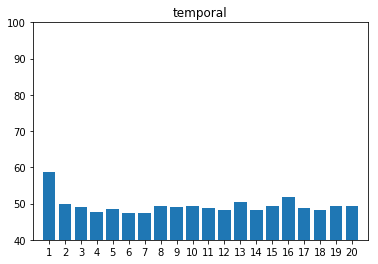

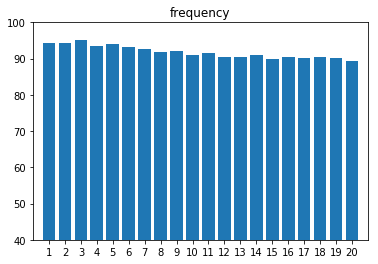

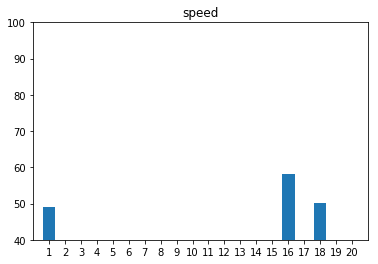

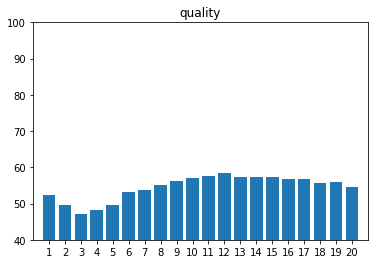

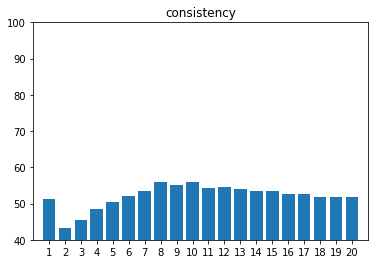

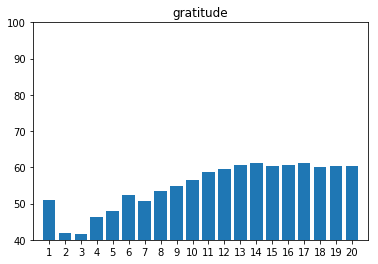

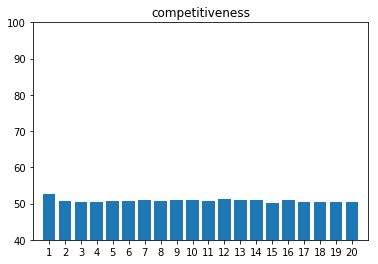

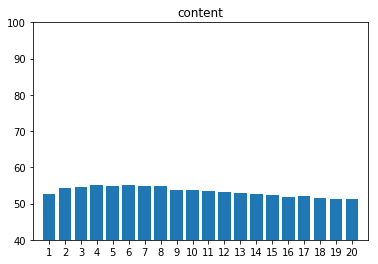

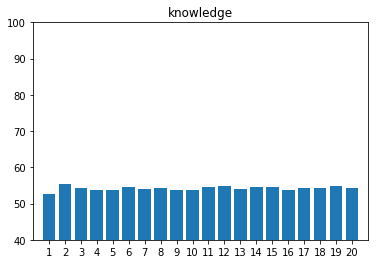

In [123]:
# Bar Chart
for title, predictions in task1_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_K)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_K, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(40, 100)
    plt.show()


In [124]:
### Category Analysis - Task 2 ###
task2_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for T in list_of_T:
        train_features = [feat for feat in feature_list if feat in features_of_task2[T].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 2, T={}'.format(name, T))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task2[T], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task2_accuracy_of_category[name] = accuracy_of_category


temporal, Task 2, T=7
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 66.16231933320859
    for each folds: [66.19075856406513, 66.45304018610592, 66.30479405190896, 66.16339004698263, 65.97637184691877, 65.91173451932946, 66.18770669403581, 66.27665640323868, 66.00752651385562, 66.15121450564489]

temporal, Task 2, T=15
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 67.37925177970907
    for each folds: [67.60752392476076, 67.28852711472885, 67.36700840410084, 67.2306067672812, 67.41760901130813, 67.30320763849166, 67.2306067672812, 67.47480969771637, 67.52321027852334, 67.34940819289831]

temporal, Task 2, T=30
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 68.35227532737778
    for each folds: [68.39428740941645, 68.56380048311226, 68.45573589863118, 68.28410391151418, 68.31588761283214, 68.69093528838411, 68.10543936

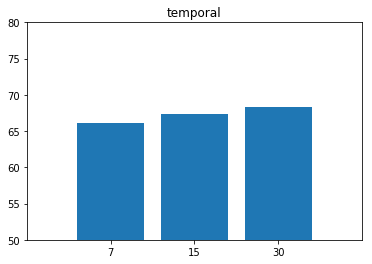

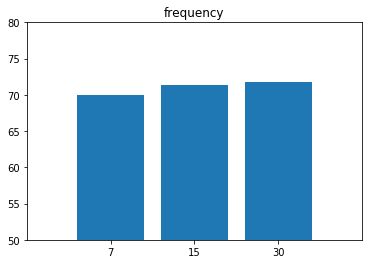

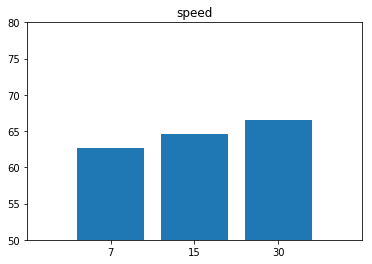

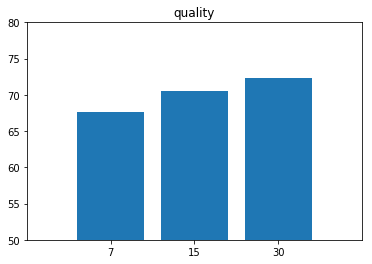

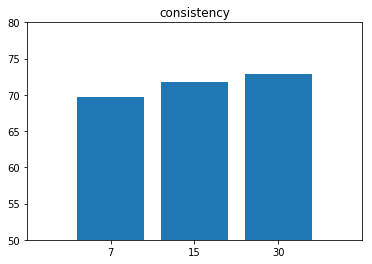

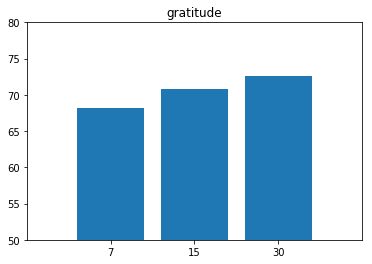

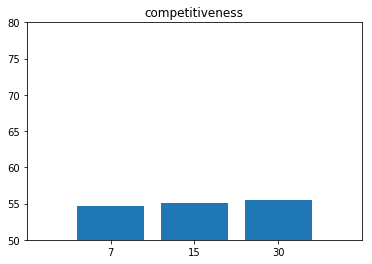

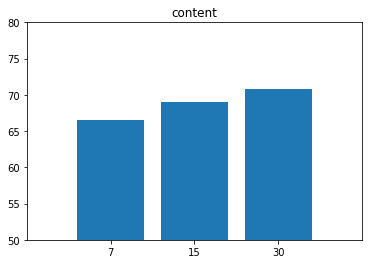

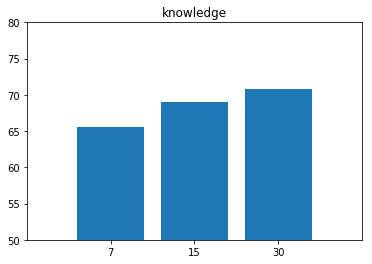

In [125]:
# Bar Chart
for title, predictions in task2_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_T)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_T, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(50, 80)
    plt.show()


In [126]:
### Temporal Feature Analysis - Task 1 ###
temporal_analysis_feature_func = {
    'gapK': lambda K: ['gap{}'.format(j) for j in range(1, K+1)],
    'last_gap': lambda K: ['gap{}'.format(K)]
}


task1_accuracy_with_time_gap = {}
for K in list_of_K:
    accuracy_with_time_gap = []
    for name, feature_func in temporal_analysis_feature_func.items():
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_with_time_gap.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_with_time_gap[K] = accuracy_with_time_gap


gapK, Task 1, K=1
    columns: ['accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered', 'time_for_first_ans', 'rep_questioner', 'rep_answerers', 'rep_co_answerers', 'num_answers_recvd']
DecisionTreeClassifier
Accuracy: 52.62213082316424
    for each folds: [52.56385701600125, 52.433270071213414, 52.82851322410461, 52.56825463156429, 52.463783256720994, 52.69536147095696, 52.48293634210893, 52.80505641454241, 52.56999582114501, 52.81027998328458]

last_gap, Task 1, K=1
    columns: ['accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered', 'time_for_first_ans', 'rep_questioner', 'rep_answerers', 'rep_co_answerers', 'num_answers_recvd']
DecisionTreeClassifier
Accuracy: 52.5911378547822
    for each folds: [52.54992774189055, 52.565598175265094, 52.59171556422266, 52.64312578353531, 52.467265635882434, 52.655314110600365, 52.41851232762223, 52.81027998328458, 52.47597158378604, 52.73366764173283]

gapK, Task 1, K=2
    columns: ['accepted_answerer_rep', 'max_rep_answerer'

In [127]:
# Table 4: Temporal gap features analysis

for K, acc in task1_accuracy_with_time_gap.items():
    print(K, acc)

1 [52.62213082316424, 52.5911378547822]
2 [54.92205922886105, 55.22616604906135]
3 [54.02032414589176, 54.481922358311394]
4 [53.53906378086468, 53.05515393191903]
5 [53.0763683102556, 53.30789703495786]
6 [54.39763138247012, 54.27645875590473]
7 [54.07474401747286, 53.84770524975448]
8 [54.41911660275529, 54.529186195142735]
9 [53.751318333494545, 53.67080885640754]
10 [53.85886603992084, 53.58184057380237]
11 [54.50397799225152, 54.49522257508877]
12 [54.905487731333594, 54.28619712021354]
13 [54.46322274552546, 54.3098508136239]
14 [54.57584890465262, 54.968324270028766]
15 [54.60758775244369, 54.261487573892666]
16 [53.912067877427944, 54.57870130139956]
17 [54.1825211458776, 54.880426736493554]
18 [53.91340977664902, 54.15438551285246]
19 [54.447712844402325, 54.70126472148293]
20 [54.02051374844342, 53.78254384201689]
